## Import Libraries

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np


## Connect and create engine with MySQL

In [2]:
import getpass 
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

# GOALS:

## In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model

#### Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [4]:
query = '''SELECT MAX(CASE WHEN YEAR(r.rental_date) = 2005 AND MONTH(r.rental_date) = 5 THEN 1 ELSE 0 END) AS rented_in_may
FROM film AS f
LEFT JOIN inventory AS i ON f.film_id = i.film_id
LEFT JOIN rental AS r ON i.inventory_id = r.inventory_id
GROUP BY f.title;'''
data=pd.read_sql(query, engine)

In [59]:
#display(data)

### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [5]:
query2='''SELECT DISTINCT rental_duration, rental_rate, length, rating, replacement_cost, special_features
FROM film;'''
data2=pd.read_sql(query2, engine)

In [7]:
#data2.shape

(1000, 6)

In [6]:
df=pd.concat([data, data2], axis=1) 

In [9]:
#df

,rented_in_may,rental_duration,rental_rate,length,rating,replacement_cost,special_features
0,1,6,0.99,86,PG,20.99,"Deleted Scenes,Behind the Scenes"
1,0,3,4.99,48,G,12.99,"Trailers,Deleted Scenes"
2,1,7,2.99,50,NC-17,18.99,"Trailers,Deleted Scenes"
3,1,5,2.99,117,G,26.99,"Commentaries,Behind the Scenes"
4,1,6,2.99,130,G,22.99,Deleted Scenes
...,...,...,...,...,...,...,...
995,0,6,0.99,183,G,9.99,"Trailers,Behind the Scenes"
996,0,4,0.99,179,NC-17,14.99,"Trailers,Behind the Scenes"
997,1,6,0.99,105,NC-17,10.99,Deleted Scenes
998,1,5,2.99,101,R,28.99,"Trailers,Deleted Scenes"


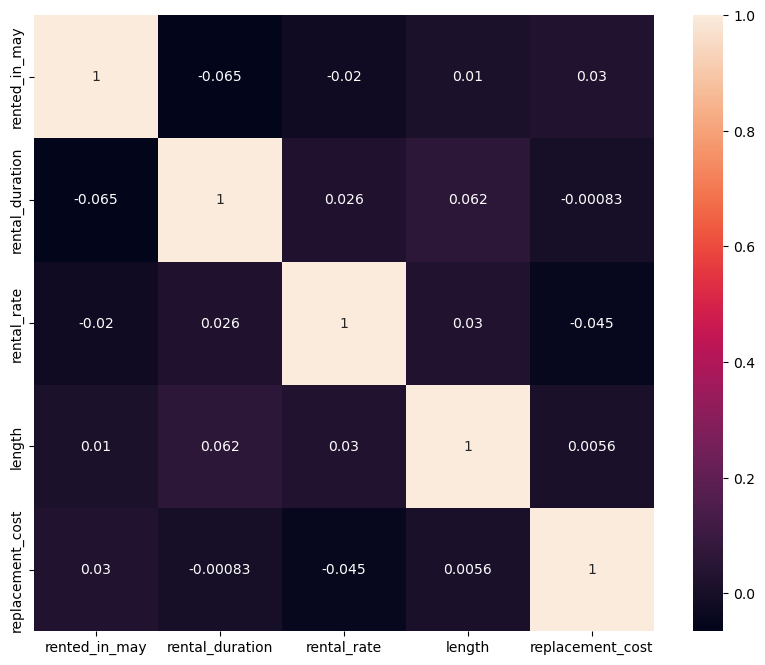

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

<AxesSubplot:>

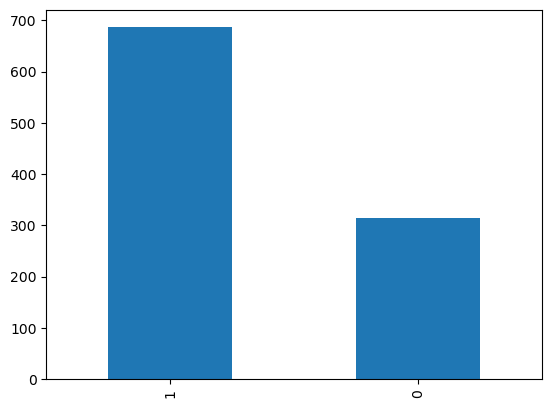

In [53]:
count_classes = df['rented_in_may'].value_counts()
count_classes
count_classes.plot(kind = 'bar')

 ## X-y

In [8]:
y = df['rented_in_may']
X = df.drop('rented_in_may', axis=1)

#### Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [12]:
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat  = X_test.select_dtypes(include = object)

### Normalizing the TRAIN set

In [13]:
transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [14]:
#X_train_cat

### Onehot econding the TRAIN set

In [15]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
encoded_cat = encoder.transform(X_train_cat).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
onehot_encoded = pd.DataFrame(encoded_cat, columns=cols)
#onehot_encoded.head()

In [16]:
X_train_transformed = pd.concat([X_train_norm, onehot_encoded], axis=1)

### Applying the model

In [17]:
from sklearn.linear_model import LogisticRegression     
classification = LogisticRegression().fit(X_train_transformed, y_train)

C:\Users\sabba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Normalizing the TEST set

In [18]:
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

### Onehot enconding the TEST set

In [19]:
encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test_cat, columns=cols)
#onehot_encoded_test.head()

In [20]:
X_test_treated = pd.concat([X_test_norm, onehot_encoded_test], axis=1)

### Creating and Analyzing Predictions

In [21]:
predictions = classification.predict(X_test_treated)
classification.score(X_test_treated, y_test)

C:\Users\sabba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\sabba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.67

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  3,  63],
       [  3, 131]], dtype=int64)

In [23]:
predictions

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [63]:
pred = classification.predict(X_test_treated)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6752577319587629
recall:  0.9776119402985075
f1:  0.7987804878048781


C:\Users\sabba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


#### Oversampling  Bonus Exercise

In [29]:
from sklearn.utils import resample

In [32]:
y_train = y_train.reset_index(drop=True) 

y_test = y_test.reset_index(drop=True) 

In [56]:
train = pd.concat([X_train_transformed, y_train],axis=1)
train

,0,1,2,3,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes",...,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",rented_in_may
0,0.75,1.0,0.964029,0.20,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.50,1.0,0.640288,0.95,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.75,1.0,0.985612,0.25,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.00,0.0,0.043165,0.30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.00,0.5,0.179856,0.45,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.00,0.5,0.575540,0.50,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
796,1.00,0.5,0.546763,0.20,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
797,0.75,0.5,0.719424,0.80,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
798,0.50,0.5,0.748201,0.65,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [34]:
no_rented = train[train['rented_in_may']==0]
yes_rented = train[train['rented_in_may']==1]

In [57]:
display(no_rented.shape)
display(yes_rented.shape)

(248, 23)

(552, 23)

In [58]:
yes_rented_oversampled = resample(yes_rented, 
                                    replace=True, 
                                    n_samples = len(no_rented),
                                    random_state=0)

In [60]:
display(no_rented.shape)
display(yes_rented_oversampled.shape)

(248, 23)

(248, 23)

In [61]:
train_oversampled = pd.concat([no_rented,yes_rented_oversampled],axis=0)
train_oversampled.head()

,0,1,2,3,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes",...,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",rented_in_may
2,0.75,1.0,0.985612,0.25,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.00,0.0,0.043165,0.30,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.00,0.5,0.179856,0.45,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
8,0.00,0.0,0.374101,0.15,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
12,0.50,0.0,0.625899,0.70,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [62]:
y_train_over = train_oversampled['rented_in_may'].copy()
X_train_over = train_oversampled.drop('rented_in_may',axis = 1).copy()

In [67]:
LR_over = LogisticRegression(random_state=0, solver='lbfgs')
LR_over.fit(X_train_over, y_train_over)
pred = LR_over.predict(X_test_treated)

print("precision: ",precision_score(y_test,pred))
print("recall: ",recall_score(y_test,pred))
print("f1: ",f1_score(y_test,pred))

precision:  0.6777777777777778
recall:  0.4552238805970149
f1:  0.5446428571428572


C:\Users\sabba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\sabba\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [68]:
confusion_matrix(y_test,pred)

array([[37, 29],
       [73, 61]], dtype=int64)

In [69]:
pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0], dtype=int64)

# Conclusion

### Even though the percentage of rented movies throughout the year is close to 70%, which is close to our prediction score, our features in the model are very limited and not very correlated to the label, making our model not much different then just guessing and, therefore, not usefull.    

## Bonus - PICKLING and UNPICKLING

In [ ]:
#import pickle
#pickle.dump(transformer, open('minmaxtransformer.p', 'wb'))  # to write ans save
#pickle.dump(classification, open('logisticregression.p', 'wb'))

#normalizer = pickle.load(open('minmaxtransformer.p','rb'))
#LR_model = pickle.load(open('logisticregressio.p','rb'))